In [1]:
!pip install torchvision
!pip install torchsummary

In [36]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

In [3]:
# Define the transforms for preprocessing
transforms = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet statistics
])


In [67]:
dataset = ImageFolder("hand14k", transform=transforms)

dataloader = DataLoader(dataset=dataset, batch_size=16)

In [78]:
import matplotlib.pyplot as plt
import numpy as np

TypeError: Invalid shape (720, 960, 21) for image data

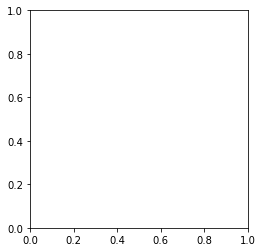

In [101]:
image_array = dataloader.dataset[20001][0].numpy()

# Transpose the array to match the shape (height, width, channels)
image_array = output['out'][0].detach().numpy().transpose(1, 2, 0)
plt.imshow(image_array)
plt.show()

In [91]:
model.eval()

# Get the input image tensor
input_tensor = dataloader.dataset[1][0].unsqueeze(0)

# Perform inference
output = model(input_tensor)

In [103]:
output['out'].shape


torch.Size([1, 21, 720, 960])

In [87]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)

/Users/ajitkumarsingh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ajitkumarsingh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[[ 7.8659105   7.8659105   7.8659105  ...  7.7487936   7.7487936
    7.7487936 ]
  [ 7.8659105   7.8659105   7.8659105  ...  7.7487936   7.7487936
    7.7487936 ]
  [ 7.8659105   7.8659105   7.8659105  ...  7.7487936   7.7487936
    7.7487936 ]
  ...
  [ 6.6263323   6.6263323   6.6263323  ...  7.14344     7.1434393
    7.1434393 ]
  [ 6.6263323   6.6263323   6.6263323  ...  7.1434393   7.1434393
    7.1434393 ]
  [ 6.6263323   6.6263323   6.6263323  ...  7.1434393   7.1434393
    7.1434393 ]]

 [[-0.41016218 -0.41016218 -0.41016218 ... -1.1791689  -1.1791689
   -1.1791689 ]
  [-0.41016218 -0.41016218 -0.41016218 ... -1.1791689  -1.1791689
   -1.1791689 ]
  [-0.41016218 -0.41016218 -0.41016218 ... -1.1791689  -1.1791689
   -1.1791689 ]
  ...
  [-0.5843424  -0.5843424  -0.5843424  ... -0.88251877 -0.88251877
   -0.88251877]
  [-0.5843424  -0.5843424  -0.5843424  ... -0.88251877 -0.88251877
   -0.88251877]
  [-0.5843424  -0.5843424  -0.5843424  ... -0.88251877 -0.88251877
   -0.88251877]

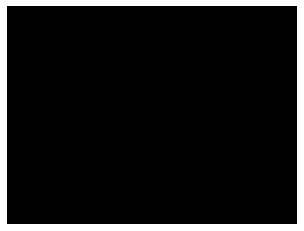

In [112]:
segmentation_map = output['out'][0].detach().numpy()

# Define a color palette for visualization
# Here, we assume 21 classes, adjust the colors accordingly
color_palette = [
    [255, 0, 0],         # Background (black)
    [255, 0, 0],       # Class 1 (red)
    [0, 255, 0],       # Class 2 (green)
    # Add more colors for other classes...
]

# Assign colors to each class in the segmentation map
colored_segmentation_map = np.zeros(segmentation_map.shape[1:] + (3,))
print(segmentation_map)
mask = segmentation_map[4] == 1
colored_segmentation_map[mask] = [255, 0, 0]
# Plot the colored segmentation map
plt.imshow(colored_segmentation_map.astype(np.uint8))
plt.axis('off')
plt.show()

In [106]:
segmentation_map.shape[0]

21

In [39]:

pretrained_model = model
# Modify the last layer of the UNet model for the new task
num_classes = 2  # Background and hand
in_chanels = pretrained_model.classifier[-1].in_channels
pretrained_model.final_conv = nn.Conv2d(in_chanels, num_classes, kernel_size=1)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

num_epochs = 10
for epoch in range(num_epochs):

    running_loss = 0.0
    
    for images, masks in zip(dataloader[0][0], dataloader[1][0]):

        images = images.to(device)
        masks = masks.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = pretrained_model(images)
        output_tensor = outputs['out']
        # Compute the loss
        loss = criterion(output_tensor, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(masks)
    print(f'Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}')
    
# Save the fine-tuned model
torch.save(pretrained_model.state_dict(), 'fine_tuned_model.pth')


FileNotFoundError: [Errno 2] No such file or directory: 'hand14k/masks/P14-R01-PastaSalad_000182.jpg'